# Imports

In [1]:
%%capture
!apt install tree

In [2]:
%matplotlib inline

import os
import glob
import time

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Data

## Download the dataset

In [3]:
!git clone https://huggingface.co/datasets/vaclavpechtor/rvl_cdip-small-200

fatal: destination path 'rvl_cdip-small-200' already exists and is not an empty directory.


## Exctract selected classes

In [4]:
!mkdir -p dataset/train
!mkdir -p dataset/validation

!mv rvl_cdip-small-200/train/handwritten dataset/train/
!mv rvl_cdip-small-200/validation/handwritten dataset/validation/

!mv rvl_cdip-small-200/train/invoice dataset/train/
!mv rvl_cdip-small-200/validation/invoice dataset/validation/

mv: cannot stat 'rvl_cdip-small-200/train/handwritten': No such file or directory
mv: cannot stat 'rvl_cdip-small-200/validation/handwritten': No such file or directory
mv: cannot stat 'rvl_cdip-small-200/train/invoice': No such file or directory
mv: cannot stat 'rvl_cdip-small-200/validation/invoice': No such file or directory


## Exploration

In [5]:
!tree -d dataset

dataset
├── train
│   ├── handwritten
│   └── invoice
└── validation
    ├── handwritten
    └── invoice

6 directories


In [6]:
datasetPath = "./dataset"
classNames = ['handwritten', 'invoice']

trainSetPath = os.path.join(datasetPath, 'train')
testSetPath = os.path.join(datasetPath, 'validation')

for cName in classNames:
    pathToImages = os.path.join(trainSetPath, cName)
    print(f"Number of {cName} training examples: {len(os.listdir(pathToImages))}")
    pathToImages = os.path.join(testSetPath, cName)
    print(f"Number of {cName} test examples: {len(os.listdir(pathToImages))}")

Number of handwritten training examples: 160
Number of handwritten test examples: 40
Number of invoice training examples: 160
Number of invoice test examples: 40


In [7]:
pathToImages = os.path.join(trainSetPath, classNames[0])

x = cv2.imread(os.path.join(pathToImages, os.listdir(pathToImages)[0]))
print(f"Image size: {x.shape}")

Image size: (1000, 754, 3)


## Visualization

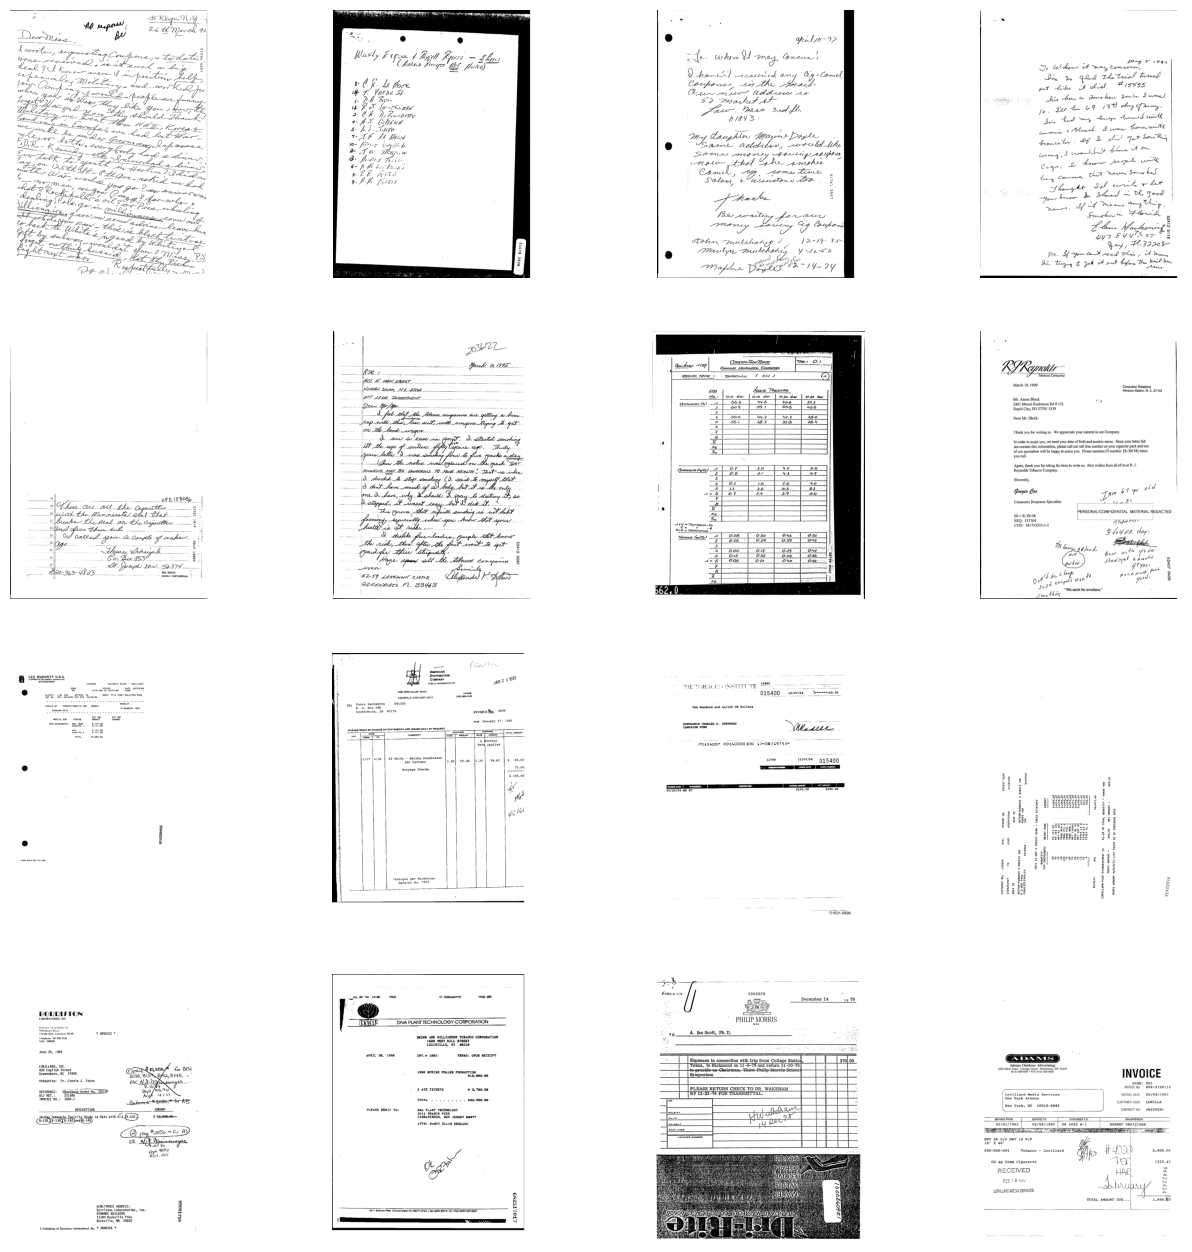

In [8]:
nrows = 4
ncols = 4
splitSize = int(nrows * ncols / 2)

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

selectedExamples = []
for cName in classNames:
    pathToImages = os.path.join(testSetPath, cName, '*')
    selectedExamples.append(glob.glob(pathToImages)[:splitSize])
selectedExamples = list(np.concatenate(selectedExamples).flat)

for i, img_path in enumerate(selectedExamples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img, cmap='gray')
plt.show()

# Model

In [9]:
import tensorflow as tf

from keras.models import Sequential, Model

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.preprocessing.image import ImageDataGenerator

This is to test if the Tensorflow version installed is the GPU version

In [10]:
if tf.test.gpu_device_name():
    print("Default GPU Device:", tf.test.gpu_device_name())
else:
    print("Using CPU")

Default GPU Device: /device:GPU:0


In [11]:
IMG_SIZE = (256, 256)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 16,
                               kernel_size = (3,3),
                               activation = 'relu',
                               input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),

    tf.keras.layers.Conv2D(filters = 32,
                           kernel_size = (3, 3),
                           activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),

    tf.keras.layers.Conv2D(filters = 64,
                           kernel_size = (3, 3),
                           activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 256, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

## Data generators

In [13]:
TRAINING_DIR = "./dataset/train/"
TEST_DIR = "./dataset/validation/"
BATCH_SIZE = 32

training_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size = IMG_SIZE,
    class_mode = 'binary',
    batch_size = BATCH_SIZE,
)

validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size = IMG_SIZE,
    class_mode = 'binary',
    batch_size = BATCH_SIZE,
)

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


## Training

In [14]:
# steps per epoch for training
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
# steps per epoch for validation/testing
STEP_SIZE_TEST = validation_generator.n // validation_generator.batch_size

print((STEP_SIZE_TRAIN, STEP_SIZE_TEST))

(10, 2)


In [15]:
model_path = "./model.h5"
EPOCHS = 30

model.compile(loss = 'binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['acc'])
checkpoint = ModelCheckpoint(model_path,
                             monitor = 'val_loss',
                             mode = 'min',
                             verbose = 1,
                             save_best_only = True)
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 5)

start_time = time.time()

history = model.fit(train_generator,
                          validation_data = validation_generator,
                          steps_per_epoch = STEP_SIZE_TRAIN,
                          validation_steps = STEP_SIZE_TEST,
                          epochs = EPOCHS,
                          verbose = 1,
                          callbacks=[checkpoint, early])

print("The model took", (time.time() - start_time) / 60, "minutes to train")

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 2.0150 - acc: 0.5344
Epoch 1: val_loss improved from inf to 0.70545, saving model to ./model.h5
10/10 [==============================] - 17s 238ms/step - loss: 2.0150 - acc: 0.5344 - val_loss: 0.7054 - val_acc: 0.4688
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 0.6884 - acc: 0.5156
Epoch 2: val_loss improved from 0.70545 to 0.67202, saving model to ./model.h5
10/10 [==============================] - 3s 273ms/step - loss: 0.6884 - acc: 0.5156 - val_loss: 0.6720 - val_acc: 0.5469
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.6581 - acc: 0.5906
Epoch 3: val_loss improved from 0.67202 to 0.62590, saving model to ./model.h5
10/10 [==============================] - 5s 540ms/step - loss: 0.6581 - acc: 0.5906 - val_loss: 0.6259 - val_acc: 0.7500
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 0.5480 - acc: 0.7312
Epoch 4: val_loss improved from 0.62590 to 0.55

## Performance metrics

### Accuracy and loss for training and validation sets

In [16]:
print('Training accuracy:', round(history.history['acc'][-1], 5) * 100, '%')
print('Test accuracy:', round(history.history['val_acc'][-1], 5) * 100, '%')
print('Training loss:', round(history.history['loss'][-1], 4))
print('Test loss:', round(history.history['val_loss'][-1], 4))

Training accuracy: 99.687 %
Test accuracy: 76.562 %
Training loss: 0.0119
Test loss: 1.1533


### Learning curves

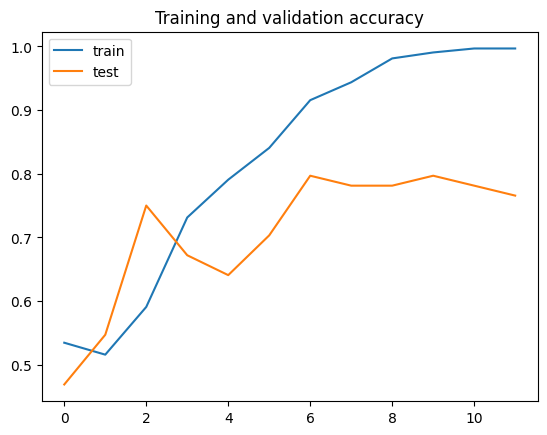

In [17]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Training and validation accuracy')
plt.legend()
# plt.savefig('acc_learning_curve.png')

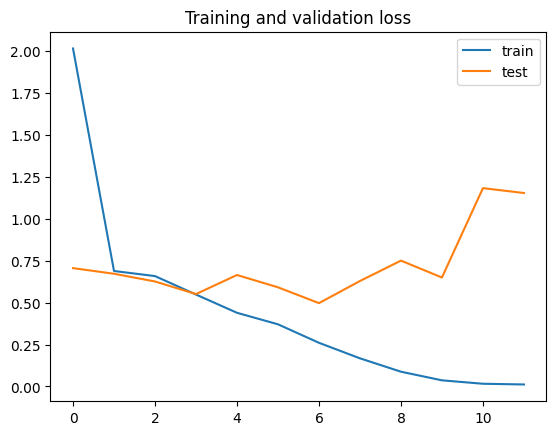

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Training and validation loss')
plt.legend()
# plt.savefig('loss_learning_curve.png')

## Download the model

In [19]:
from google.colab import files
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>